<a href="https://colab.research.google.com/github/jamelof23/Latent_Attribute_Privacy/blob/main/work1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

fatal: destination path 'Latent_Attribute_Privacy' already exists and is not an empty directory.
✅ Generator ready.
[INFO] Upload latent .npy (shape (1,512) or (512,))


Saving 777.npy to 777 (2).npy
Original latent image:


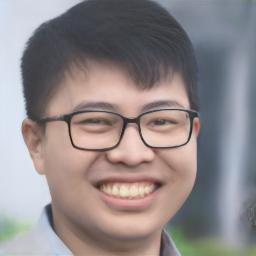

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [32]:
# Setup + load InterfaceGAN generator (GPU) + boundaries + latent
# ==== ENV & REPO ====
import os, sys, io, cv2, numpy as np
from PIL import Image
import IPython.display as display

os.chdir('/content')
CODE_DIR = 'Latent_Attribute_Privacy'
!git clone -q https://github.com/jamelof23/Latent_Attribute_Privacy $CODE_DIR
os.chdir(f'./{CODE_DIR}/models/interfacegan_official')
!mkdir -p models/pretrain
!wget -q https://www.dropbox.com/s/qyv37eaobnow7fu/stylegan_ffhq.pth?dl=1 -O models/pretrain/stylegan_ffhq.pth

# ==== IMPORTS ====
from models.model_settings import MODEL_POOL
from models.stylegan_generator import StyleGANGenerator
from google.colab import files  # for auto-downloads

def build_generator(model_name):
    gan_type = MODEL_POOL[model_name]['gan_type']
    assert gan_type == 'stylegan'
    return StyleGANGenerator(model_name)

model_name = "stylegan_ffhq"
latent_space_type = "W"  # we work in W
generator = build_generator(model_name)
synthesis_kwargs = {'latent_space_type': 'W'}
print("✅ Generator ready.")

# ==== BOUNDARIES: Age (target), Gender (non-target) ====
# Put your .npy boundaries under: Latent_Attribute_Privacy/models/interfacegan_official/boundaries/
# e.g. stylegan_ffhq_age_w_boundary.npy, stylegan_ffhq_gender_w_boundary.npy
age_path    = 'boundaries/stylegan_ffhq_age_w_boundary.npy'
gender_path = 'boundaries/stylegan_ffhq_gender_w_boundary.npy'
assert os.path.exists(age_path) and os.path.exists(gender_path), "Boundary npy files not found."

b_age    = np.load(age_path).astype(np.float64).reshape(-1)
b_gender = np.load(gender_path).astype(np.float64).reshape(-1)

# Normalize
b_age    /= (np.linalg.norm(b_age) + 1e-12)
b_gender /= (np.linalg.norm(b_gender) + 1e-12)

# ==== UPLOAD LATENT ====
print("[INFO] Upload latent .npy (shape (1,512) or (512,))")
uploaded = files.upload()
latent_path = list(uploaded.keys())[0]
latent_codes = np.load(latent_path).astype(np.float64)
if latent_codes.ndim == 2 and latent_codes.shape == (1,512):
    w0 = latent_codes[0]
elif latent_codes.ndim == 1 and latent_codes.shape[0] == 512:
    w0 = latent_codes
else:
    raise ValueError(f"Latent must be (1,512) or (512,), got {latent_codes.shape}")

# Quick preview synth
def imshow(image, viz=256):
    h, w, _ = image.shape
    if (h,w)!=(viz,viz):
        image = cv2.resize(image, (viz, viz))
    buf = io.BytesIO(); Image.fromarray(image.astype(np.uint8)).save(buf,'jpeg')
    display.display(display.Image(buf.getvalue()))

x0 = generator.easy_synthesize(w0[np.newaxis,:], **synthesis_kwargs)['image'][0]
print("Original latent image:")
imshow(x0)

# Save & auto-download the original image
orig_path = '/content/original.png'
Image.fromarray(x0.astype(np.uint8)).save(orig_path)
try:
    files.download(orig_path)
except Exception as e:
    print("Download skipped (Colab-only):", e)


[diag] cos(angle(age, gender)) BEFORE = 0.0706
[diag] cos(angle(age_orth, gender)) AFTER  = 1.4156e-13
Subspace dim k=1, ambient d=512
[anchor refined] α ≈ 5.0000  score ≈ -9.9130e-03
Reference (re-centered) image:


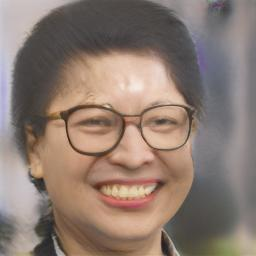

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [33]:
# ==== SUBSPACE S from boundaries (Age target; can add more cols for joint case) ====
# For single-attribute Age: N = [b_age]; for joint add more columns, e.g., np.stack([b_age, b_smile, ...], 1)

# (A) Orthogonalize Age against Gender to reduce leakage
def cosine(u, v):
    return float(np.dot(u, v) / ((np.linalg.norm(u)+1e-12)*(np.linalg.norm(v)+1e-12)))

print(f"[diag] cos(angle(age, gender)) BEFORE = {cosine(b_age, b_gender):.4f}")
b_age_orth = b_age - (np.dot(b_age, b_gender)) * b_gender
b_age_orth /= (np.linalg.norm(b_age_orth) + 1e-12)
print(f"[diag] cos(angle(age_orth, gender)) AFTER  = {cosine(b_age_orth, b_gender):.4e}")

# Use the orthogonalized Age for the subspace
N = b_age_orth[:,None]  # d x k ; here k=1

# Orthonormalize N -> Q_S (Gram–Schmidt via QR)
Q, _ = np.linalg.qr(N)  # d x k, columns orthonormal
k = Q.shape[1]
d = Q.shape[0]
print(f"Subspace dim k={k}, ambient d={d}")

# Projector Pi_S = Q Q^T (we'll use Q directly for sampling)
# Pi_S = Q @ Q.T  # not needed explicitly for sampling

# ==== Reference edit (temporary) ====
alpha_init = 2.0  # initial guess (not final)
w_tmp = w0 + alpha_init * b_age_orth
x_tmp = generator.easy_synthesize(w_tmp[np.newaxis,:], **synthesis_kwargs)['image'][0]
Image.fromarray(x_tmp.astype(np.uint8)).save('/content/ref_alpha_init.png')

# ==== CLIP scorer f_S  (public attribute scorer) ====
!pip -q install open_clip_torch ftfy regex
import torch, open_clip

device = 'cuda' if torch.cuda.is_available() else 'cpu'
clip_model, clip_preprocess, _ = open_clip.create_model_and_transforms(
    'ViT-B-16', pretrained='laion2b_s34b_b88k', device=device)
clip_model = clip_model.to(device)
clip_model.eval()
clip_tokenizer = open_clip.get_tokenizer('ViT-B-16')

# Prompts (face-specific helps stability)
texts_age    = clip_tokenizer(["a young adult face, portrait", "an elderly face, portrait"]).to(device)
texts_gender = clip_tokenizer(["a portrait photo of a male face", "a portrait photo of a female face"]).to(device)

with torch.no_grad():
    text_emb_age    = clip_model.encode_text(texts_age);    text_emb_age    /= text_emb_age.norm(dim=-1, keepdim=True)
    text_emb_gender = clip_model.encode_text(texts_gender); text_emb_gender /= text_emb_gender.norm(dim=-1, keepdim=True)

def _prep_batch(np_batch):
    ims = [Image.fromarray(img.astype(np.uint8)) for img in np_batch]
    ims = torch.stack([clip_preprocess(im) for im in ims]).to(device)
    return ims

@torch.no_grad()
def clip_scores(np_batch):
    """
    Returns dict with COSINE scores (no logit_scale) for age (old-young) and gender (woman-man).
    Each entry shape: [batch]
    """
    ims = _prep_batch(np_batch)
    img_emb = clip_model.encode_image(ims); img_emb /= img_emb.norm(dim=-1, keepdim=True)
    logits_age    = (img_emb @ text_emb_age.T)      # [B,2] cosine
    logits_gender = (img_emb @ text_emb_gender.T)   # [B,2] cosine
    age_score    = (logits_age[:,1] - logits_age[:,0]).detach().cpu().numpy()       # old - young
    gender_score = (logits_gender[:,1] - logits_gender[:,0]).detach().cpu().numpy() # woman - man
    return {'age': age_score, 'gender': gender_score}

# Re-center w_ref near CLIP age boundary (score ≈ 0)
def line_search_alpha_to_score0(w0, v, a_min=-5.0, a_max=5.0, steps=201):
    alphas = np.linspace(a_min, a_max, steps)
    lat_batch = w0[None,:] + alphas[:,None] * v[None,:]
    bs = int(max(1, getattr(generator, 'batch_size', 4)))
    imgs_list = []
    for s in range(0, steps, bs):
        imgs_list.append(generator.easy_synthesize(lat_batch[s:s+bs], **synthesis_kwargs)['image'])
    imgs = np.concatenate(imgs_list, axis=0)
    scores = clip_scores(imgs)['age']  # >0 older, <0 younger
    idx = int(np.argmin(np.abs(scores)))
    return float(alphas[idx]), float(scores[idx]), alphas, scores

def find_bracket_for_zero(alphas, scores):
    # Find consecutive indices with sign change
    for i in range(len(alphas)-1):
        if np.sign(scores[i]) == 0:
            return alphas[i], alphas[i]
        if np.sign(scores[i]) != np.sign(scores[i+1]):
            return alphas[i], alphas[i+1]
    return None

def refine_alpha_bisection(w0, v, a_lo, a_hi, scorer_fn, iters=14):
    alo, ahi = float(a_lo), float(a_hi)
    # if degenerate bracket (exact zero), return
    if alo == ahi:
        x_mid = generator.easy_synthesize((w0 + alo*v)[None,:], **synthesis_kwargs)['image'][0]
        s_mid = scorer_fn([x_mid])['age'][0]
        return alo, s_mid
    # ensure opposite signs
    x_lo = generator.easy_synthesize((w0 + alo*v)[None,:], **synthesis_kwargs)['image'][0]
    x_hi = generator.easy_synthesize((w0 + ahi*v)[None,:], **synthesis_kwargs)['image'][0]
    s_lo = scorer_fn([x_lo])['age'][0]
    s_hi = scorer_fn([x_hi])['age'][0]
    if np.sign(s_lo) == np.sign(s_hi):
        # fallback: return the closer-to-zero endpoint
        if abs(s_lo) <= abs(s_hi): return alo, s_lo
        else: return ahi, s_hi
    for _ in range(iters):
        amid = 0.5*(alo+ahi)
        x_mid = generator.easy_synthesize((w0 + amid*v)[None,:], **synthesis_kwargs)['image'][0]
        s_mid = scorer_fn([x_mid])['age'][0]
        if s_mid == 0: return amid, s_mid
        if np.sign(s_mid) == np.sign(s_lo):
            alo, s_lo = amid, s_mid
        else:
            ahi, s_hi = amid, s_mid
    return amid, s_mid

alpha_star0, score0, alphas_scan, scores_scan = line_search_alpha_to_score0(w0, b_age_orth, -5.0, 5.0, 201)
br = find_bracket_for_zero(alphas_scan, scores_scan)
if br is not None:
    alpha_star, score_at_alpha = refine_alpha_bisection(w0, b_age_orth, br[0], br[1], clip_scores, iters=14)
else:
    alpha_star, score_at_alpha = alpha_star0, score0

print(f"[anchor refined] α ≈ {alpha_star:.4f}  score ≈ {score_at_alpha:.4e}")

w_ref = (w0 + alpha_star * b_age_orth).astype(np.float64)
x_ref = generator.easy_synthesize(w_ref[np.newaxis,:], **synthesis_kwargs)['image'][0]
Image.fromarray(x_ref.astype(np.uint8)).save('/content/ref_recentered.png')
print("Reference (re-centered) image:")
imshow(x_ref)

# Auto-download reference images
for p in ['/content/ref_alpha_init.png', '/content/ref_recentered.png']:
    try: files.download(p)
    except Exception as e: print("Download skipped:", e)


In [34]:
# Estimate L_s by finite differences
# ==============================
# L_S ESTIMATION (central diff, chunked)
# ==============================
import numpy as np

def estimate_Ls_central_diff_chunked(
    w_ref: np.ndarray,
    Q: np.ndarray,
    scorer_fn,                 # callable: np_batch[H,W,3] -> np.array shape [B] or [B,m]
    h: float = 0.05,
    num_dirs: int = 32,
    seed: int = 42,
    batch_size: int = None,    # override; if None, use generator.batch_size or 4
    vector_norm_axis: int = -1 # if scorer returns [B,m], take L2 along this axis
):
    """
    Estimates ||J_f(w_ref) Q||_2 using central differences along random unit vectors v in R^k:
        ||J_f Q||_2 ≈ max_v || f(w_ref + h Q v) - f(w_ref - h Q v) || / (2h)
    """
    assert Q.ndim == 2, "Q must be (d,k)"
    d, k = Q.shape
    assert w_ref.shape[0] == d, f"w_ref shape {w_ref.shape} not compatible with Q (d={d})"

    rng = np.random.default_rng(seed)
    dirs = rng.normal(size=(num_dirs, k))
    dirs /= (np.linalg.norm(dirs, axis=1, keepdims=True) + 1e-12)

    bs_default = int(max(1, getattr(generator, 'batch_size', 4)))
    bs = int(batch_size) if batch_size is not None else bs_default

    deriv_all = []
    for start in range(0, num_dirs, bs):
        vblock = dirs[start:start+bs]
        lat_plus  = []
        lat_minus = []
        for v in vblock:
            dv = (Q @ v).astype(np.float64)
            lat_plus.append (w_ref + h*dv)
            lat_minus.append(w_ref - h*dv)
        lat_plus  = np.stack(lat_plus,  axis=0)
        lat_minus = np.stack(lat_minus, axis=0)

        imgs_plus  = generator.easy_synthesize(lat_plus,  **synthesis_kwargs)['image']
        imgs_minus = generator.easy_synthesize(lat_minus, **synthesis_kwargs)['image']

        s_plus  = scorer_fn(imgs_plus)
        s_minus = scorer_fn(imgs_minus)

        s_plus  = np.asarray(s_plus)
        s_minus = np.asarray(s_minus)

        if s_plus.ndim == 1:
            deriv_blk = np.abs(s_plus - s_minus) / (2*h)
        elif s_plus.ndim == 2:
            diff = s_plus - s_minus
            deriv_blk = np.linalg.norm(diff, axis=vector_norm_axis) / (2*h)
        else:
            raise ValueError(f"scorer_fn must return [B] or [B,m], got shape {s_plus.shape}")

        deriv_all.append(deriv_blk)

    deriv = np.concatenate(deriv_all, axis=0)
    Ls_hat = float(np.max(deriv))
    return Ls_hat, deriv

# Ambient (R^d) Lipschitz estimate for isotropic DP baseline
def estimate_L_full_central_diff(
    w_ref, h=0.05, num_dirs=32, seed=0, batch_size=None, scorer_fn=lambda imgs: clip_scores(imgs)['age']):
    rng = np.random.default_rng(seed)
    d = w_ref.shape[0]
    dirs = rng.normal(size=(num_dirs, d))
    dirs /= (np.linalg.norm(dirs, axis=1, keepdims=True) + 1e-12)
    bs_default = int(max(1, getattr(generator, 'batch_size', 4)))
    bs = bs_default if batch_size is None else int(batch_size)
    deriv_all = []
    for start in range(0, num_dirs, bs):
        ublk = dirs[start:start+bs]
        lat_plus  = w_ref[None,:] + h*ublk
        lat_minus = w_ref[None,:] - h*ublk
        imgs_p = generator.easy_synthesize(lat_plus,  **synthesis_kwargs)['image']
        imgs_m = generator.easy_synthesize(lat_minus, **synthesis_kwargs)['image']
        s_p = np.asarray(scorer_fn(imgs_p))
        s_m = np.asarray(scorer_fn(imgs_m))
        deriv_all.append(np.abs(s_p - s_m)/(2*h))
    deriv = np.concatenate(deriv_all, axis=0)
    return float(np.max(deriv)), deriv

# Convenience wrappers for current CLIP setup
def clip_age_scalar(np_batch):     return clip_scores(np_batch)['age']
def clip_age_gender_vector(np_batch):
    s = clip_scores(np_batch)
    return np.stack([s['age'], s['gender']], axis=1)

# Estimate subspace and ambient Lipschitz (with safety margin)
Ls_hat, _      = estimate_Ls_central_diff_chunked(w_ref=w_ref, Q=Q, scorer_fn=clip_age_scalar, h=0.05, num_dirs=32, seed=42)
Lfull_hat, _   = estimate_L_full_central_diff(w_ref, h=0.05, num_dirs=32, seed=123)

SAFETY = 1.25
Ls_est_safe   = Ls_hat   * SAFETY
Lfull_est_safe= Lfull_hat* SAFETY

C_sub = Ls_est_safe    * np.sqrt(2.0 * np.log(1.25/1e-5))
C_iso = Lfull_est_safe * np.sqrt(2.0 * np.log(1.25/1e-5))

print(f"L_S estimate @w_ref: {Ls_hat:.4f}   (with safety → {Ls_est_safe:.4f})")
print(f"L_full estimate @w_ref: {Lfull_hat:.4f}   (with safety → {Lfull_est_safe:.4f})")
print(f"[calibration] C_sub = {C_sub:.4f}   C_iso = {C_iso:.4f}   (δ=1e-5)")


L_S estimate @w_ref: 0.1834   (with safety → 0.2293)
L_full estimate @w_ref: 0.1388   (with safety → 0.1735)
[calibration] C_sub = 1.1107   C_iso = 0.8404   (δ=1e-5)


In [35]:
# Monte‑Carlo experiment using your calibration
from skimage.metrics import structural_similarity as ssim
import numpy as np, math, os
from PIL import Image
from google.colab import files

# Budgets (paper)
eps_list = [0.2, 0.5, 1.0, 2.0]
delta = 1e-5
tau_list = [0.5, 1.0]
K = 200  # samples per budget (for quick run set 50)

out_dir = '/content/results_empirical'
os.makedirs(out_dir, exist_ok=True)

# Metrics
def identity_ssim(img_ref, img):
    return float(ssim(img_ref, img, channel_axis=2, data_range=255))
def perceptual_1mssim(img_ref, img):
    return 1.0 - identity_ssim(img_ref, img)

# Attack via CLIP (target ‘age’), label from reference
y_ref = (clip_scores([x_ref])['age'][0] >= 0.0)
def attack_success(img):
    return 1 if (clip_scores([img])['age'][0] >= 0.0) == y_ref else 0

# Leakage via CLIP (non-target ‘gender’)
g_ref = clip_scores([x_ref])['gender'][0]
def leakage(img):
    return abs(clip_scores([img])['gender'][0] - g_ref)

def clip_to_tau(vec, tau):
    n = np.linalg.norm(vec)
    return vec if n <= tau else vec * (tau / n)

csv_path = f"{out_dir}/summary_age_CLIPcalibrated.csv"
if not os.path.exists(csv_path):
    with open(csv_path, 'w') as f:
        f.write('method,eps,delta,tau,sigma,Ls_est,Lfull_est,attack_mean,attack_std,'
                'leak_mean,leak_std,id_mean,id_std,perc_mean,perc_std,alpha,margin\n')

d = Q.shape[0]; k = Q.shape[1]

print(f"[CALIBRATION] L_S (safe) = {Ls_est_safe:.4f}   L_full (safe) = {Lfull_est_safe:.4f}")
for tau in tau_list:
    for eps in eps_list:
        sigma_sub = (Ls_est_safe    * tau * math.sqrt(2.0 * math.log(1.25/delta))) / eps
        sigma_iso = (Lfull_est_safe * tau * math.sqrt(2.0 * math.log(1.25/delta))) / eps
        print(f"[τ={tau}] [ε={eps}] σ_sub={sigma_sub:.4f}  σ_iso={sigma_iso:.4f}")

        stats_sub, stats_iso_dp, stats_iso_nm = [], [], []

        for ksample in range(K):
            # Subspace (your mechanism): Δw = Q z, z~N(0,σ_sub^2 I_k), then clip
            z = np.random.normal(0.0, sigma_sub, size=(k,))
            dw_sub = clip_to_tau((Q @ z).astype(np.float64), tau)

            # Isotropic DP (ambient): Δw ~ N(0, σ_iso^2 I_d), then clip
            dw_dp  = clip_to_tau(np.random.normal(0.0, sigma_iso, size=(d,)), tau)

            # Isotropic norm-matched: unit u scaled to ||dw_sub||, then clip
            u = np.random.normal(0.0, 1.0, size=(d,)); u /= (np.linalg.norm(u) + 1e-12)
            dw_nm = clip_to_tau(u * (np.linalg.norm(dw_sub) + 1e-12), tau)

            # Synthesize
            x_sub = generator.easy_synthesize((w_ref + dw_sub)[np.newaxis,:], **synthesis_kwargs)['image'][0]
            x_dp  = generator.easy_synthesize((w_ref + dw_dp )[np.newaxis,:], **synthesis_kwargs)['image'][0]
            x_nm  = generator.easy_synthesize((w_ref + dw_nm )[np.newaxis,:], **synthesis_kwargs)['image'][0]

            # Metrics
            atk_sub, atk_dp, atk_nm = attack_success(x_sub), attack_success(x_dp), attack_success(x_nm)
            leak_sub, leak_dp, leak_nm = leakage(x_sub), leakage(x_dp), leakage(x_nm)
            id_sub, id_dp, id_nm = identity_ssim(x_ref, x_sub), identity_ssim(x_ref, x_dp), identity_ssim(x_ref, x_nm)
            pq_sub, pq_dp, pq_nm = perceptual_1mssim(x_ref, x_sub), perceptual_1mssim(x_ref, x_dp), perceptual_1mssim(x_ref, x_nm)

            stats_sub.append((atk_sub, leak_sub, id_sub, pq_sub))
            stats_iso_dp.append((atk_dp,  leak_dp,  id_dp,  pq_dp ))
            stats_iso_nm.append((atk_nm,  leak_nm,  id_nm,  pq_nm ))

            # save a few triplets for F1 (ref, iso_dp, sub)
            if ksample < 6:
                tag_sub    = f'eps{eps}_del{delta}_tau{tau}_sig{round(sigma_sub,4)}'
                tag_iso_dp = f'eps{eps}_del{delta}_tau{tau}_sig{round(sigma_iso,4)}'
                base_sub    = f"{out_dir}/age_sub_{tag_sub}_k{ksample}"
                base_iso_dp = f"{out_dir}/age_isoDP_{tag_iso_dp}_k{ksample}"
                Image.fromarray(x_ref.astype(np.uint8)).save(base_sub + "_ref.png")
                Image.fromarray(x_dp.astype(np.uint8)).save(base_iso_dp + "_iso_dp.png")
                Image.fromarray(x_sub.astype(np.uint8)).save(base_sub + "_sub.png")

            if (ksample+1) % max(1, K//5) == 0:
                print(f"  progress {ksample+1}/{K}")

        def agg(stats):
            A = np.array(stats, dtype=float)
            return np.nanmean(A, axis=0), np.nanstd(A, axis=0)

        m_sub, s_sub       = agg(stats_sub)
        m_iso_dp, s_iso_dp = agg(stats_iso_dp)
        m_iso_nm, s_iso_nm = agg(stats_iso_nm)

        with open(csv_path, 'a') as f:
            f.write(f'sub,{eps},{delta},{tau},{sigma_sub},{Ls_est_safe},{Lfull_est_safe},'
                    f'{m_sub[0]},{s_sub[0]},{m_sub[1]},{s_sub[1]},'
                    f'{m_sub[2]},{s_sub[2]},{m_sub[3]},{s_sub[3]},{alpha_star},{SAFETY}\n')
            f.write(f'iso_dp,{eps},{delta},{tau},{sigma_iso},{Ls_est_safe},{Lfull_est_safe},'
                    f'{m_iso_dp[0]},{s_iso_dp[0]},{m_iso_dp[1]},{s_iso_dp[1]},'
                    f'{m_iso_dp[2]},{s_iso_dp[2]},{m_iso_dp[3]},{s_iso_dp[3]},{alpha_star},{SAFETY}\n')
            f.write(f'iso_nm,{eps},{delta},{tau},{np.nan},{Ls_est_safe},{Lfull_est_safe},'
                    f'{m_iso_nm[0]},{s_iso_nm[0]},{m_iso_nm[1]},{s_iso_nm[1]},'
                    f'{m_iso_nm[2]},{s_iso_nm[2]},{m_iso_nm[3]},{s_iso_nm[3]},{alpha_star},{SAFETY}\n')

print("✅ calibrated run complete →", out_dir)

# Auto-download the CSV immediately
try:
    files.download(csv_path)
except Exception as e:
    print("Download skipped:", e)


[CALIBRATION] L_S (safe) = 0.2293   L_full (safe) = 0.1735
[τ=0.5] [ε=0.2] σ_sub=2.7767  σ_iso=2.1009
  progress 40/200
  progress 80/200
  progress 120/200
  progress 160/200
  progress 200/200
[τ=0.5] [ε=0.5] σ_sub=1.1107  σ_iso=0.8404
  progress 40/200
  progress 80/200
  progress 120/200
  progress 160/200
  progress 200/200
[τ=0.5] [ε=1.0] σ_sub=0.5553  σ_iso=0.4202
  progress 40/200
  progress 80/200
  progress 120/200
  progress 160/200
  progress 200/200
[τ=0.5] [ε=2.0] σ_sub=0.2777  σ_iso=0.2101
  progress 40/200
  progress 80/200
  progress 120/200
  progress 160/200
  progress 200/200
[τ=1.0] [ε=0.2] σ_sub=5.5534  σ_iso=4.2018
  progress 40/200
  progress 80/200
  progress 120/200
  progress 160/200
  progress 200/200
[τ=1.0] [ε=0.5] σ_sub=2.2213  σ_iso=1.6807
  progress 40/200
  progress 80/200
  progress 120/200
  progress 160/200
  progress 200/200
[τ=1.0] [ε=1.0] σ_sub=1.1107  σ_iso=0.8404
  progress 40/200
  progress 80/200
  progress 120/200
  progress 160/200
  progre

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [36]:
# Make F2–F5 plots and a simple F1 grid (robust CSV loader that merges old/new schemas)
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import math, glob, os, csv, numpy as np
from google.colab import files
import zipfile

raw_csv = f"{out_dir}/summary_age_CLIPcalibrated.csv"
norm_csv = f"{out_dir}/summary_age_CLIPcalibrated_merged.csv"

# --- Normalize CSV: handle both 15-col (old) and 17-col (new) rows ---
col17 = ['method','eps','delta','tau','sigma','Ls_est','Lfull_est',
         'attack_mean','attack_std','leak_mean','leak_std',
         'id_mean','id_std','perc_mean','perc_std','alpha','margin']
col15 = ['method','eps','delta','tau','sigma','Ls_est',
         'attack_mean','attack_std','leak_mean','leak_std',
         'id_mean','id_std','perc_mean','perc_std','alpha']

rows = []
with open(raw_csv, newline='') as f:
    rdr = csv.reader(f)
    first = next(rdr, None)

    # If the first row is a header, ignore it; otherwise treat it as data
    def _ingest(r):
        if not r:
            return
        if len(r) == 17:
            rows.append(dict(zip(col17, r)))
        elif len(r) == 15:
            d = dict(zip(col15, r))
            d['Lfull_est'] = ''
            d['margin']    = ''
            rows.append(d)
        else:
            # skip malformed rows
            pass

    if first and not (len(first) > 0 and first[0] == 'method'):
        _ingest(first)
    for r in rdr:
        _ingest(r)

# Build dataframe with unified schema
df = pd.DataFrame(rows, columns=col17)

# Cast numerics
for c in col17:
    if c != 'method':
        df[c] = pd.to_numeric(df[c], errors='coerce')

# Basic sanity: drop rows with missing eps/tau
df = df.dropna(subset=['eps','tau'])
df.to_csv(norm_csv, index=False)
print("Normalized CSV written:", norm_csv)

# From now on, use the normalized dataframe `df`
if df.empty:
    raise RuntimeError("Normalized CSV is empty. Re-run the Monte-Carlo cell (D) to generate results.")

# --- Plots ---
def plot_metric(metric, ylabel, tau):
    sub = df[(df['tau'] == tau)]
    if sub.empty:
        print(f"No rows for tau={tau}")
        return None
    plt.figure()
    # legend order preference
    order = [m for m in ['iso_dp','iso_nm','sub'] if m in sub['method'].unique()]
    for method in order:
        dsub = sub[sub['method'] == method].sort_values('eps')
        if dsub.empty:
            continue
        y = dsub[metric].values
        yerr = dsub[metric.replace('mean','std')].values
        plt.errorbar(dsub['eps'], y, yerr=yerr, marker='o', label=method)
    plt.xlabel('ε'); plt.ylabel(ylabel); plt.title(f'{ylabel} vs ε (τ={tau}, δ=1e-5)')
    plt.legend(); plt.grid(True, alpha=0.2)
    fn = f"{out_dir}/{metric}_vs_eps_tau{tau}.png"
    plt.savefig(fn, bbox_inches='tight'); plt.close()
    print("Saved", fn)
    return fn

saved_figs = []
for tau in sorted(df['tau'].dropna().unique()):
    fn = plot_metric('attack_mean', 'Attack success (↓)', tau)       # F2
    if fn: saved_figs.append(fn)
    fn = plot_metric('leak_mean',   'Non-target leakage (↓)', tau)    # F3
    if fn: saved_figs.append(fn)
    fn = plot_metric('id_mean',     'Identity SSIM (↑)', tau)         # F4
    if fn: saved_figs.append(fn)
    # F5: Privacy vs Perceptual
    subdf = df[df['tau']==tau]
    if not subdf.empty:
        plt.figure()
        order = [m for m in ['iso_dp','iso_nm','sub'] if m in subdf['method'].unique()]
        for method in order:
            dmethod = subdf[subdf['method']==method]
            if dmethod.empty:
                continue
            plt.scatter(1 - dmethod['attack_mean'], dmethod['perc_mean'], label=method)
        plt.xlabel('Privacy = 1 - attack success (↑)')
        plt.ylabel('Perceptual loss = 1 - SSIM (↓)')
        plt.title(f'Privacy–Utility tradeoff (τ={tau}, δ=1e-5)'); plt.legend(); plt.grid(True, alpha=0.2)
        fn = f"{out_dir}/privacy_utility_tau{tau}.png"
        plt.savefig(fn, bbox_inches='tight'); plt.close(); print("Saved", fn)
        saved_figs.append(fn)

# --- F1 grid (ref + iso_dp + sub), robust to float formatting ---
def find_first_matching(path_glob):
    g = glob.glob(path_glob)
    return g[0] if len(g) > 0 else None

rows = []
for tau in sorted(df['tau'].unique()):
    for eps in sorted(df['eps'].unique()):
        sub_row    = df[(df['tau']==tau)&(df['eps']==eps)&(df['method']=='sub')]
        isodp_row  = df[(df['tau']==tau)&(df['eps']==eps)&(df['method']=='iso_dp')]
        if sub_row.empty or isodp_row.empty:
            continue

        # Use wildcards for sigma to avoid float-string mismatches
        base_sub_glob    = f"{out_dir}/age_sub_eps{eps}_del1e-05_tau{tau}_sig*_k0"
        base_iso_dp_glob = f"{out_dir}/age_isoDP_eps{eps}_del1e-05_tau{tau}_sig*_k0"
        base_sub    = find_first_matching(base_sub_glob)
        base_iso_dp = find_first_matching(base_iso_dp_glob)
        if not base_sub or not base_iso_dp:
            continue

        p_ref = base_sub + "_ref.png"
        p_iso = base_iso_dp + "_iso_dp.png"
        p_sub = base_sub + "_sub.png"
        if all(os.path.exists(p) for p in [p_ref, p_iso, p_sub]):
            trip = [Image.open(p_ref), Image.open(p_iso), Image.open(p_sub)]
            w = sum(im.width for im in trip); h = max(im.height for im in trip)
            row = Image.new('RGB', (w,h))
            x=0
            for im in trip:
                row.paste(im, (x,0)); x+=im.width
            rows.append(row)

if rows:
    H = sum(r.height for r in rows); W = max(r.width for r in rows)
    grid = Image.new('RGB', (W,H)); y=0
    for r in rows:
        grid.paste(r,(0,y)); y += r.height
    grid_path = f"{out_dir}/F1_qual_grid.png"
    grid.save(grid_path)
    print("Saved", grid_path)
    saved_figs.append(grid_path)
else:
    print("F1 grid assembly skipped (no triplets found).")

# Auto-download key outputs individually (figures + grid)
for p in saved_figs:
    try: files.download(p)
    except Exception as e: print("Download skipped:", e)

# Zip ALL results and download once (recommended)
zip_path = '/content/results_empirical.zip'
with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as z:
    for root, _, files_list in os.walk(out_dir):
        for name in files_list:
            full = os.path.join(root, name)
            arc  = os.path.relpath(full, start=os.path.dirname(out_dir))
            z.write(full, arcname=arc)
print("Zipped:", zip_path)
try:
    files.download(zip_path)
except Exception as e:
    print("Download skipped:", e)


Normalized CSV written: /content/results_empirical/summary_age_CLIPcalibrated_merged.csv
Saved /content/results_empirical/attack_mean_vs_eps_tau0.5.png
Saved /content/results_empirical/leak_mean_vs_eps_tau0.5.png
Saved /content/results_empirical/id_mean_vs_eps_tau0.5.png
Saved /content/results_empirical/privacy_utility_tau0.5.png
Saved /content/results_empirical/attack_mean_vs_eps_tau1.0.png
Saved /content/results_empirical/leak_mean_vs_eps_tau1.0.png
Saved /content/results_empirical/id_mean_vs_eps_tau1.0.png
Saved /content/results_empirical/privacy_utility_tau1.0.png
F1 grid assembly skipped (no triplets found).


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Zipped: /content/results_empirical.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [37]:
# === OPTIONAL: Verification (calibration, mechanism, win-rates, latent leakage) ===
import math, numpy as np, pandas as pd, csv, os

csv_path = f"{out_dir}/summary_age_CLIPcalibrated.csv"

# --- Normalize CSV: accept both 15-col (old) and 17-col (new) formats ---
col17 = ['method','eps','delta','tau','sigma','Ls_est','Lfull_est',
         'attack_mean','attack_std','leak_mean','leak_std',
         'id_mean','id_std','perc_mean','perc_std','alpha','margin']
col15 = ['method','eps','delta','tau','sigma','Ls_est',
         'attack_mean','attack_std','leak_mean','leak_std',
         'id_mean','id_std','perc_mean','perc_std','alpha']

def load_normalized(csv_path):
    rows = []
    with open(csv_path, newline='') as f:
        rdr = csv.reader(f)
        first = next(rdr, None)

        def ingest(r):
            if not r:
                return
            # skip header line if present
            if r[0] == 'method':
                return
            if len(r) == 17:
                rows.append(dict(zip(col17, r)))
            elif len(r) == 15:
                d = dict(zip(col15, r))
                d['Lfull_est'] = ''
                d['margin']    = ''
                rows.append(d)
            else:
                # malformed row length → skip
                return

        # If the first line is data (not header), ingest it
        if first and first[0] != 'method':
            ingest(first)
        for r in rdr:
            ingest(r)

    df = pd.DataFrame(rows, columns=col17)
    # cast numerics (leave 'method' as string)
    for c in col17:
        if c != 'method':
            df[c] = pd.to_numeric(df[c], errors='coerce')
    # drop rows with missing eps/tau
    df = df.dropna(subset=['eps','tau'])
    return df

dfv = load_normalized(csv_path)
print("Rows:", len(dfv))
print("Methods present:", sorted(dfv['method'].dropna().unique()))

# --- Calibration constants (robust) ---
def _get_global(name, default=np.nan):
    return globals()[name] if name in globals() else default

delta_val = _get_global('delta', 1e-5)
Ls_safe   = _get_global('Ls_est_safe', np.nan)     # subspace L_S (with safety)
Lf_safe   = _get_global('Lfull_est_safe', np.nan)  # ambient L (with safety), optional

# Fallback from CSV if not defined in this session
if (not np.isfinite(Ls_safe)) and 'Ls_est' in dfv.columns and dfv['Ls_est'].notna().any():
    # prefer 'sub' rows for Ls_est
    tmp = dfv[dfv['method']=='sub']['Ls_est'].dropna()
    if tmp.shape[0] == 0:
        tmp = dfv['Ls_est'].dropna()
    if tmp.shape[0] > 0:
        Ls_safe = float(tmp.iloc[0])

if (not np.isfinite(Lf_safe)) and 'Lfull_est' in dfv.columns and dfv['Lfull_est'].notna().any():
    # prefer iso_dp rows for Lfull_est, else any available
    tmp = dfv[dfv['method']=='iso_dp']['Lfull_est'].dropna()
    if tmp.shape[0] == 0:
        tmp = dfv['Lfull_est'].dropna()
    if tmp.shape[0] > 0:
        Lf_safe = float(tmp.iloc[0])

def _calib_const(Lsafe):
    return (Lsafe * math.sqrt(2.0 * math.log(1.25/delta_val))) if np.isfinite(Lsafe) else float('nan')

C_sub = _calib_const(Ls_safe)
C_iso = _calib_const(Lf_safe)
print(f"[calibration] C_sub={C_sub:.4f}  C_iso={C_iso:.4f}  (δ={delta_val})")

# --- Mechanism audit (subspace projection + clipping) ---
b = int(max(1, getattr(generator, 'batch_size', 4)))
tau = 0.5; eps = 0.5
sigma_sub = (Ls_safe * tau * math.sqrt(2.0 * math.log(1.25/delta_val))) / eps
d, k = Q.shape

z = np.random.normal(0.0, sigma_sub, size=(b, k))
dw_sub = (Q @ z.T).T
# projection residual
proj = (Q @ (Q.T @ dw_sub.T)).T
residual = np.linalg.norm(dw_sub - proj, axis=1) / (np.linalg.norm(dw_sub, axis=1) + 1e-12)

def clip_tau_batch(vecs, tau):
    n = np.linalg.norm(vecs, axis=1, keepdims=True)
    return vecs * np.minimum(1.0, tau/(n+1e-12))

dw_sub_c = clip_tau_batch(dw_sub, tau)
norms = np.linalg.norm(dw_sub_c, axis=1)
print(f"[audit] subspace residual (median, max): {np.median(residual):.2e}, {np.max(residual):.2e}")
print(f"[audit] clip ||Δw_sub|| ≤ τ ? max norm = {norms.max():.4f}  (τ={tau})")

# --- Win-rate summary: sub vs best available isotropic baseline ---
def choose_baseline(methods):
    if 'iso_dp' in methods: return 'iso_dp'
    if 'iso'    in methods: return 'iso'
    if 'iso_nm' in methods: return 'iso_nm'
    return None

baseline = choose_baseline(set(dfv['method'].dropna().unique()))
if baseline is None:
    print("No isotropic baseline found (iso_dp / iso / iso_nm); skipping win-rate summary.")
else:
    def win_rate(df, metric, better='lower', m1='sub', m2=baseline):
        pivot = df.pivot_table(index=['tau','eps'], columns='method', values=f'{metric}_mean')
        # keep only rows where both methods exist
        cols = [c for c in [m1, m2] if c in pivot.columns]
        if len(cols) < 2:
            return 0, 0
        pivot = pivot.dropna(subset=cols, how='any')
        if pivot.empty:
            return 0, 0
        if better == 'lower':
            wins = (pivot[m1] < pivot[m2]).sum()
        else:
            wins = (pivot[m1] > pivot[m2]).sum()
        return int(wins), int(pivot.shape[0])

    for metr, better in [('attack','lower'), ('leak','lower'), ('id','higher')]:
        w, t = win_rate(dfv, metr, better, 'sub', baseline)
        print(f"{metr} ({'↓' if better=='lower' else '↑'})  sub better than {baseline} in {w}/{t} budgets")

    # Perceptual gap (keep utility similar)
    pivot_pq = dfv.pivot_table(index=['tau','eps'], columns='method', values='perc_mean')
    if ('sub' in pivot_pq.columns) and (baseline in pivot_pq.columns):
        rel_gap = (pivot_pq['sub'] - pivot_pq[baseline]).abs().mean()
        print(f"mean |Δ(perceptual)| between sub and {baseline}: {float(rel_gap):.4f}")
    else:
        print("Perceptual comparison skipped (columns missing).")

# --- Latent leakage sanity (gender direction) ---
Kcheck = 200
z = np.random.normal(0.0, sigma_sub, size=(Kcheck, k))
dw_sub = (Q @ z.T).T
dw_sub = clip_tau_batch(dw_sub, tau)

u = np.random.normal(0.0, 1.0, size=(Kcheck, d))
u /= (np.linalg.norm(u, axis=1, keepdims=True) + 1e-12)
dw_nm = u * (np.linalg.norm(dw_sub, axis=1, keepdims=True) + 1e-12)
dw_nm = clip_tau_batch(dw_nm, tau)

print("latent leakage |Δw·b_gender|  mean(sub), mean(iso_nm):",
      float(np.mean(np.abs(dw_sub @ b_gender))),
      float(np.mean(np.abs(dw_nm  @ b_gender))))


Rows: 46
Methods present: ['iso', 'iso_dp', 'iso_nm', 'sub']
[calibration] C_sub=1.1107  C_iso=0.8404  (δ=1e-05)
[audit] subspace residual (median, max): 3.19e-16, 6.25e-16
[audit] clip ||Δw_sub|| ≤ τ ? max norm = 0.5000  (τ=0.5)
attack (↓)  sub better than iso_dp in 7/8 budgets
leak (↓)  sub better than iso_dp in 0/8 budgets
id (↑)  sub better than iso_dp in 2/8 budgets
mean |Δ(perceptual)| between sub and iso_dp: 0.0065
latent leakage |Δw·b_gender|  mean(sub), mean(iso_nm): 5.3400617723078363e-14 0.013584510783328643
